# Object Detection System

## 개요

### 실습 목표

1. Object detection 모델을 학습할 수 있습니다.
2. RetinaNet 모델을 활용한 시스템을 만들 수 있습니다.

### 학습 내용

1. 자율주행 보조장치
2. RetinaNet
3. 데이터 준비부터 모델 학습, 결과 확인까지
4. 프로젝트: 자율주행 보조 시스템 만들기

## KITTI dataset

* 자율 주행 보조장치 Object Detection 요구사항
1. 사람이 카메라에 감지되면 정지
2. 차량이 일정 크기 이상으로 감지되면 정지
* KITTI dataset은 자율 주행을 위한 dataset, 2D object detection 뿐 아니라 깊이를 포함한 3D object detection 라벨 등을 제공.

### 라이브러리 불러오기

In [1]:
import copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/3/data'

### Dataset 다운로드

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

2022-10-12 17:29:47.086298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 17:29:47.617747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


### Data 확인

* ds_info : 불러온 dataset의 정보를 확인

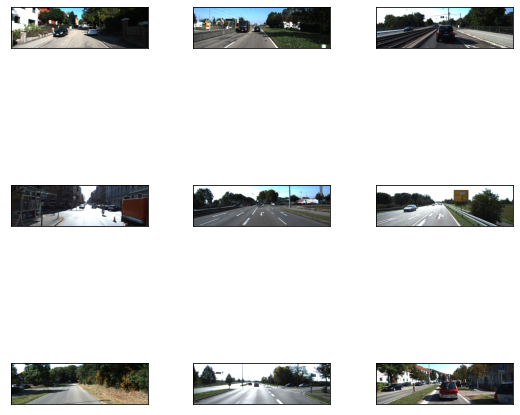

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/3/data/kitti/3.2.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': S

* train : 6347개
* test : 711개
* validation : 423개 

## 데이터 직접 확인하기

* ds_train.take(1) : train 데이터셋에서 하나씩 sample을 얻을 수 있음

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.55,  1.85], dtype=float32)>, 'bbox': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.48656   , 0.47563607, 0.56890666, 0.49858293],
       [0.45904   , 0.33416265, 0.50829333, 0.3629549 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 2.85,  2.63, 12.34],
       [ 1.46,  1.86,  4.01]], dtype=float32)>, 'location': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ -0.39,   1.89,  73.51],
       [-14.82,   2.44,  60.5 ]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, 'rotation_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.56,  1.61], dtype=float32)>, 'truncated': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, 'type': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 0])>}


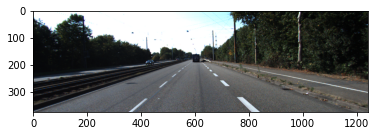

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

* 이미지와 라벨을 얻음.
* 이미지의 bounding box(bbox) 확인

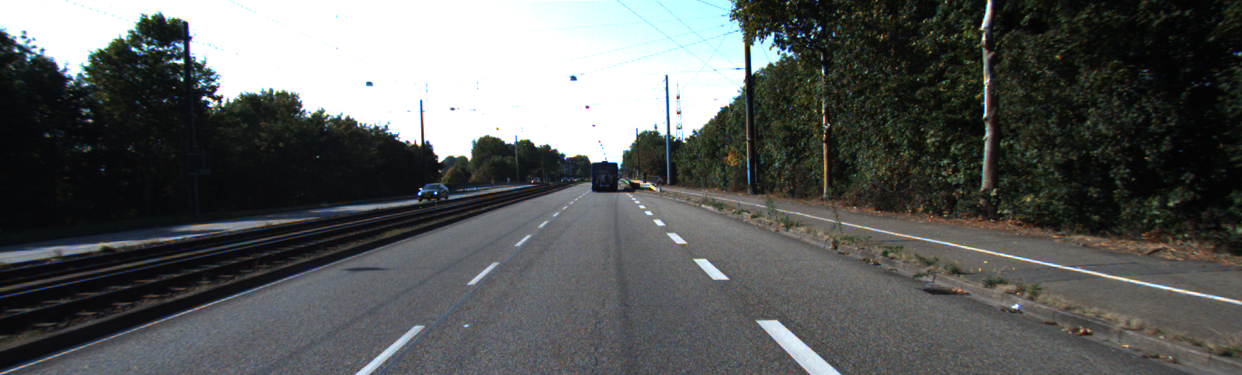

In [6]:
img

In [7]:
bbox = objects['bbox'].numpy()
display(bbox)
# bounding box의 개수
len(bbox)

array([[0.48656   , 0.47563607, 0.56890666, 0.49858293],
       [0.45904   , 0.33416265, 0.50829333, 0.3629549 ]], dtype=float32)

2

width = 1242  height =  375
590.7399927377701 192.5400048494339 619.239998281002 161.66000068187714
415.0300143957138 202.8600051999092 450.7900038957596 184.39000099897385


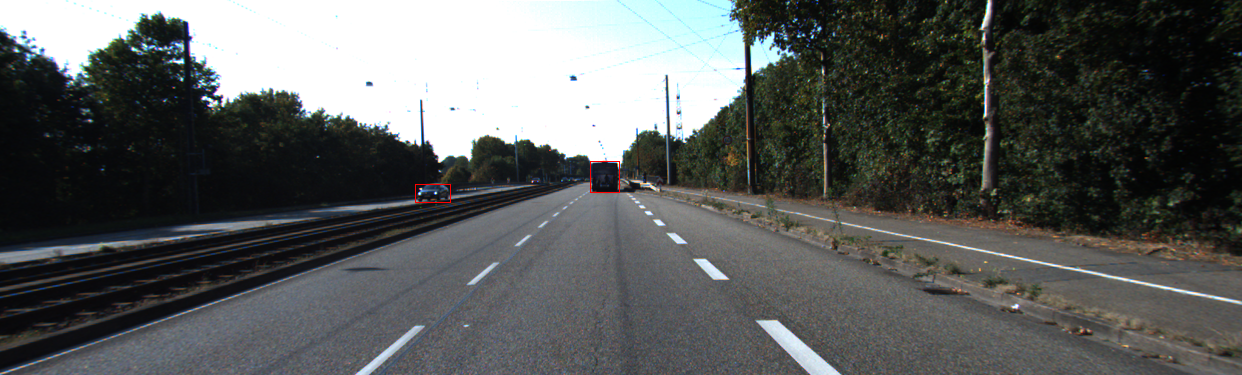

In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    # bounding box의 좌표는 원래 이미지의 비례값만 가지고 있기 때문에 정확한 위치값을 구하는 정보가 필요합니다.
    width, height = input_image.size
    print('width =', width, ' height = ', height)
    # box는 이미지상에서 좌측 상단부터의 비율을 나타냅니다.
    # box = [y_min, x_min, y_max, x_max] 순서로 있습니다.
    for box in object_bbox:
        x_min = box[1] * width
        y_min = height - box[0] * height
        x_max = box[3] * width
        y_max = height - box[2] * height
        
        print(x_min,y_min,x_max,y_max)
        
        # 여기서 좌표는 좌측하단에서부터의 위치이므로 x좌표는 동일하나
        # y 좌표는 높이에서 빼줘야 합니다.
        draw.rectangle([x_min,y_min,x_max,y_max], outline = (255,0,0))
    
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## RetinaNet 

* one stage detector는 two stage detector 보다 더 빠르지만 성능이 더 낮은 단점이 있습니다.
* 이를 극복하기 위해 focal loss와 FPN(Feature Pyramid Network)를 적용한 네트워크를 사용합니다.

### Focal Loss

* 배경보다 물체를 더 학습을 잘하자 = 물체의 경우 loss를 작게 만들자
* 보통 우리의 모델은 물체보다는 배경을 많이 학습하게 됩니다.
* 여기서 loss를 개선해서 정확도를 높입니다.

* Cross-Entropy를 기반으로 만들어짐.
* $CE(p_{t})$ 의 앞단에 $(1-p_{t})^{\gamma}$ 라는 modulating factor를 붙여줌
* $CE(p_{t}) = -log(p_{t})$
* $FL(p_{t}) = -(1-p_{t})^{\gamma} log(p_{t})$
* $\gamma$가 0이 되면 modulating facotr 가 1이 되어 일반적인 교차 엔트로피 $$

### FPN(Feature Pyramid Network)

* 특성을 피라미드처럼 쌓아서 사용하는 방식.
* 백본의 여러 레이어를 한꺼번에 쓰겠다라는데 의의

## 데이터 준비

### 데이터 파이프라인

* 주어진 KITTI 데이터를 학습에 맞는 형태로 변경 필요.
* 이때 사용할 데이터 파이프라인을 구축(4단계)
1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
* 독립적인 함수 작성

* box = [y_min, x_min, y_max, x_max] 이였으므로
* [x_min, y_min, x_max, y_max]로 바꿔주는 함수 입니다.

In [9]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis = -1)

* [tf.random.uniform](https://www.tensorflow.org/api_docs/python/tf/random/uniform)
  - 균등분포로 나온 무작위 값을 포함하는 특수한 형태를 가지는 텐서를 리턴한다.

In [10]:
test1 = tf.random.uniform(())
print(test1)

tf.Tensor(0.00070381165, shape=(), dtype=float32)


* [tf.image.flip_left_right()](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right)
* 이미지를 수평으로 뒤집습니다.(좌우) - 거리 이미지이니 상하로 뒤집지 않습니다.(데이터에 맞게 선택한 것)

* [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack)
* list 안의 텐서들을 연결합니다. axis의 값에 따라 연결 방법이 달라집니다.
* axis는 -2이상 2미만 입니다. (1차원 기준이므로 정확히는 [-(R+1), R+1) )

In [11]:
x = tf.constant([1, 4, 7])
y = tf.constant([2, 5, 8])
z = tf.constant([3, 6, 9])

print(x)
print(y)
print(z)

xyz_1 = tf.stack([x,y,z])
print('default\n', xyz_1)
xyz_2 = tf.stack([x,y,z], axis = -2)
print('axis = -2\n', xyz_2)
xyz_3 = tf.stack([x,y,z], axis = -1)
print('axis = -1\n',xyz_3)
xyz_4 = tf.stack([x,y,z], axis = 0)
print('axis = 0\n',xyz_4)
xyz_5 = tf.stack([x,y,z], axis = 1)
print('axis = 1\n',xyz_5)

tf.Tensor([1 4 7], shape=(3,), dtype=int32)
tf.Tensor([2 5 8], shape=(3,), dtype=int32)
tf.Tensor([3 6 9], shape=(3,), dtype=int32)
default
 tf.Tensor(
[[1 4 7]
 [2 5 8]
 [3 6 9]], shape=(3, 3), dtype=int32)
axis = -2
 tf.Tensor(
[[1 4 7]
 [2 5 8]
 [3 6 9]], shape=(3, 3), dtype=int32)
axis = -1
 tf.Tensor(
[[1 2 3]
 [4 5 6]
 [7 8 9]], shape=(3, 3), dtype=int32)
axis = 0
 tf.Tensor(
[[1 4 7]
 [2 5 8]
 [3 6 9]], shape=(3, 3), dtype=int32)
axis = 1
 tf.Tensor(
[[1 2 3]
 [4 5 6]
 [7 8 9]], shape=(3, 3), dtype=int32)


* 좌우 반전으로 이므로 $x_{min}$, $x_{max}$ 의 위치가 $1 - x_{max}$, $1 - x_{min}$ 이 됩니다.

<img src = 'image/Flip_Left_Right.png' width = 50% height = 50%>

In [12]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
            ## [1- Xmax, Ymin, 1- Xmin, Ymax]
        )
    return image, boxes

* 이미지 크기 변경시 고려할 점
1. 비율을 그대로 유지되어야 함
2. 최대/최소 크기 제한
3. 크기를 변경한 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수

* 실제로 입력할 이미지를 어떻게 바꿀지는 min_side, max_side, min_side_range, stride 등에 의해 결정.
* 학습이 완료된 모델을 사용할 때는 입력할 이미지를 다양한 크기로 바꿀 필요가 없으니 분기처리 해주기.

* [tf.math.reduce_min](https://www.tensorflow.org/api_docs/python/tf/math/reduce_min) : tensor의 차원들 중에서 작은 값을 가져옴

In [13]:
def resize_and_pad_image(image, training=True):
    
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
        
    ratio = min_side / tf.reduce_min(image_shape)
    
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    
    image_shape = ratio * image_shape
    
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    
    return image, image_shape, ratio

In [14]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

* 준비된 함수들을 연결시켜줍시다.

In [15]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### 인코딩

* One stage detector에서는 Anchor Box라는 정해져 있는 위치, 크기, 비율 중에서 하나로 물체의 위치가 결정됩니다.
* 그래서 기본적으로 Anchor box를 생성해줘야 합니다.
* Anchor Box로 생성되는 것은 물체 위치 후보라고 생각하면 됩ㄴ디ㅏ.
* 물체 위치를 주관식이 아닌 객관식으로 풀게 하는 것.

* 에를 들어 100개의 Anchor Box를 생성했다고 가정하면 이미 만들어진 100개의 Anchor Box에 해당하지 않는 위치, 크기, 비율에 물체가 있을 수 없습니다.(음 그렇대)
* 100개의 Anchor Box 중에 가장 근접한 하나가 선택이 됩니다.
* 이렇게 선택된 Anchor Box를 기초로 정확한 위치를 찾아냅니다.
* Anchor Box로부터 상하좌우로 떨어진 정도, 가로 세로의 크기 차이를 미세하게 찾아냅니다.
* 게다가 Anchor Box가 촘촘하게 겹치도록 생성되기 때문에 물체를 잘 찾아낼 수 있습니다.

* RetinaNet에서는 FPN을 사용하기 때문에 Anchor Box가 더 많이 필요합니다.
* FPN의 각 층마다 Anchor Box가 필요하기 때문입니다.
* RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어 있기 때문에 각 level에서 만드는 Anchor Box도 약속되어 있음.

* 논문에서와 같이 Anchor Box를 생성해봅니다.

In [16]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

* Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형해줘야 합니다.
* 데이터 원본의 bbox는 주관식 정답이라고 생각하면 딤.
* 하지만 모델은 객관식으로 풀어야하기 때문에 주관식 정답에 가장 가까운 객관식 정답으로 바꿔줘야 모델을 학습시킬 수 있습니다.
* 여기서 사용되는데 IoU 입니다.
* IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크해 두는 것.
* IoU를 계산할 수 있는 함수를 만듭니다.

In [17]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

* 실제 라벨을 Anchor Box에 맞춰주는 클래스를 만들어 봅시다.
* 위에서 작성한 compute_iou 함수를 이용하여 IoU를 구하고 그것을 기준으로 물체에 하당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해 줍니다.
* 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산합니다.
* 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해 기록합니다.

In [18]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

## 모델 작성

### Feature Pyramid

* RetinaNet에서는 FPN(Feature Pyramid Network)를 사용.
* 완전히 동일한 것은 아니고 약간 수정해서 사용.

In [19]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

* Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요.
* 그것을 head
* Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layr가 추출되고 나면 feature를 바탕으로 class 예상하고 box도 예상합니다.
* class와 box가 모두 맞을 수도, class와 box 하나만 맞을 수도, 둘다 틀릴 수 있음
* class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 것이 중요합니다.
* 그래서 각각의 head를 만들어줍니다. head 부분은 유사한 형태로 만들 수 있으니 build_head 함수를 만들고 두 번 호출하면 됩니다.

In [20]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

* RetinaNet의 backbone은 ResNet50입니다.
* FPNdp 이용할 수 있도록 중간 레이어도 output으로 연결해 줍니다.

In [21]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

* RetinaNet을 완성해 봅시다.
* Backbone + FPN + classification 용 head + box 용 head 입니다.

In [22]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

* Loss 준비
* RetinaNet에서는 Focal Loss를 사용함.
* Box Regression에는 사용하지않고 Classification Loss를 계산하는데만 사용됩니다.
* Box Regression에는 Smooth L1 Loss를 사용했네요.
* Smooth L1 Loss를 사용하는 Box Regression에는 delta를 기준으로 계산이 달라집니다.
* Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의하세요!

In [23]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

## 모델 학습

In [24]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

* 모델이 간단하게 만들어졌습니다.
* Learning Rate를 정해봅시다.
* 우리 상황에 맞춰서 Learning Rate를 바꿔줍니다.
* Optimizer는 동일하게 SGD를 사용합니다.

In [25]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

* 전처리르 위한 파이프라인도 만들어 줍니다.

In [26]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

* 1 epoch당 학습 시긴이 상당히 오래 걸리기 때문에
* 여기서는 학습 시키는 예시 코드만 보여드립니다.
* 뒤에선 미리 학습된 모델을 불러와 사용할 예정입니다.

In [27]:
# model_dir = 'data/checkpoints'
# callbacks_list = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
#         monitor="loss",
#         save_best_only=False,
#         save_weights_only=True,
#         verbose=1,
#     )
# ]

# epochs = 1

# model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     callbacks=callbacks_list
# )

## 결과 확인하기

* 학습된 모델을 불러옵시다.

In [28]:
# model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
model_dir = 'data/checkpoints'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

* NMS은 직접 구현하지 않고 주어진 tf.image.combined_non_max_suppression를 사용했습니다.
* [tf.image.combined_non_max_suppression](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

In [29]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

* 추론 가능한 모델을 조립합니다.

In [30]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

* 모델 추론 결과를 시각화 할 함수를 만들어 줍니다.

In [31]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

* 전처리를 위한 함수를 만듭니다.
* 학습을 위한 전처리와 추론을 위한 전처리가 다릅니다.
* 추론을 위한 전처리가 훨씬 더 간단합니다.

In [32]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

2022-10-12 17:29:59.528475: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


1/1 [==============================] - 4s 4s/step


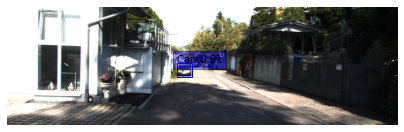

1/1 [==============================] - 0s 72ms/step


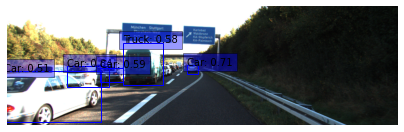

In [33]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# 프로젝트: 자율 주행 보조 시스템 만들기

## 자율 주행 시스템 만들기

* 입력으로 이미지 경로를 받습니다.
* 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
* 조건은 다음과 같습니다.
  - 사람이 한 명 이상 있는 경우
  - 차량의 크기(width or height)가 300px이상인 경우

* Go랑 Stop을 정하는 함수를 만듭니다.

In [34]:
def go_stop_decision(image, boxes, classes):
    # 초기 결과값은 "Go" 입니다.
    result = "Go"
    # image은 numpy화 합니다.
    image = np.array(image, dtype=np.uint8)
    #  박스와 클래스를 통해 Go, Stop을 결정합니다.
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        # print("w :", w)
        # print("h :", h)
        # print("class :", cls)
        if cls in ['Van', 'Car', 'Truck', 'Cyclist', 'Tram']: 
            if w >= 300 or h >= 300:
                result = "Stop"
        elif cls in ['Pedestrian', 'Person_sitting']:
            result = "Stop"
        # print(cls)
    
    # print(result)
    return result

In [35]:
# img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'
img_path = '/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/3/image/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 이미지 불러오기
    image = tf.keras.utils.load_img(img_path)
    print(type(image))
    # 이미지 전처리
    input_image, ratio = prepare_image(image)
    # 인퍼런스 모델 적용
    detections = inference_model.predict(input_image)
    # 감지된 오브젝트 개수
    num_detections = detections.valid_detections[0]
    # 오브젝트들의 class 이름
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    result = go_stop_decision(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
    )
    
    return result

print(self_drive_assist(img_path))

<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 69ms/step
Stop


## 자율주행 시스템 평가하기

* test_system 함수를 통해 평가해봅시다.
* 10장에 대해 Go, Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해봅시다.

In [36]:
import os

def test_system(func):
    work_dir = '/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/3/image'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(pred, answer)
        if pred == answer:
            score += 10
    
    print(f"{score}점입니다.")

test_system(self_drive_assist)

<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 71ms/step
Stop Stop
<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 72ms/step
Stop Stop
<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 75ms/step
Stop Stop
<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 74ms/step
Go Stop
<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 75ms/step
Stop Stop
<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 73ms/step
Go Go
<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 74ms/step
Go Go
<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 78ms/step
Go Go
<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0s 75ms/step
Go Go
<class 'PIL.PngImagePlugin.PngImageFile'>
1/1 [==============================] - 0

### 회고

* 이번 프로젝트에서 어려웠던 점
    - 전처리와 lMS의 코드 부분을 해석하는게 어려웠습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된점
    - 좌우 반전에 다른 x좌표의 변환에 대해 알게 되었습니다.
  * 아직 모호한 점
    - RetinaNet에 대한 코드 연습
* 루브릭 평가를 맞추기 위해 시도한 점
    - 자동차의 범주에 자전거와 전차를 추가했습니다.
    - Predict와 정답을 출력하였습니다.